# Instacart Analysis

## 1. Data Importing & Description

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
import warnings
warnings.filterwarnings('ignore')

### orders (3.4m rows, 206k users):

order_id: order identifier

user_id: customer identifier

eval_set: which evaluation set this order belongs in (see SET described below)

order_number: the order sequence number for this user (1 = first, n = nth)

order_dow: the day of the week the order was placed on

order_hour_of_day: the hour of the day the order was placed on

days_since_prior: days since the last order, capped at 30 (with NAs for order_number = 1)

In [3]:
orders = pd.read_csv('orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### products (50k rows):

product_id: product identifier

product_name: name of the product

aisle_id: foreign key

department_id: foreign key

In [4]:
products = pd.read_csv('products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### aisles (134 rows):

aisle_id: aisle identifier

aisle: the name of the aisle

In [5]:
aisles = pd.read_csv('aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### deptartments (21 rows):

department_id: department identifier

department: the name of the department

In [6]:
departments = pd.read_csv('departments.csv')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


### order_products__SET (30m+ rows):

order_id: foreign key

product_id: foreign key

add_to_cart_order: order in which each product was added to cart

reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

#### where SET is one of the Three following evaluation sets (eval_set in orders):

"prior": orders prior to that users most recent order (~3.2m orders)

"train": training data (~131k orders)

"test": test data (~75k orders)

In [7]:
# all the prior orders made by a customer
priors = pd.read_csv('order_products__prior.csv')
priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [8]:
# the training data for model training
train = pd.read_csv('order_products__train.csv')
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## 2. Exploratory Data Analysis

In [9]:
order_products = pd.concat([train, priors], axis=0)

print("The order_products size is : ", order_products.shape)
order_products.head()

The order_products size is :  (33819106, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [10]:
orders_unique = len(set(order_products.order_id))
products_unique = len(set(order_products.product_id))
print("There are %s orders for %s products" %(orders_unique, 
                                              products_unique))

There are 3346083 orders for 49685 products


### Ratio of Reorder

In [11]:
ratio = order_products.groupby("reordered")["product_id"]
ratio = ratio.aggregate({'Number_Reordered': 'count'}).reset_index()
ratio['Reorderd_Ratios'] = ratio["Number_Reordered"].apply(lambda x: x /ratio['Number_Reordered'].sum())
ratio

,reordered,Number_Reordered,Reorderd_Ratios
0,0,13863746,0.409938
1,1,19955360,0.590062


The reorder ratio is 59%

### Most Frequent Reorder Product (descending order by count)

In [12]:
most_reorder = order_products.groupby("product_id")["reordered"]
df_reorder = most_reorder.aggregate({'Number_Reordered': 'count'}).reset_index()
df_reorder = pd.merge(df_reorder, products[['product_id', 'product_name']], how='left', on=['product_id'])
df_reorder = df_reorder.sort_values(by='Number_Reordered', ascending=False)[:20]
df_reorder

,product_id,Number_Reordered,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


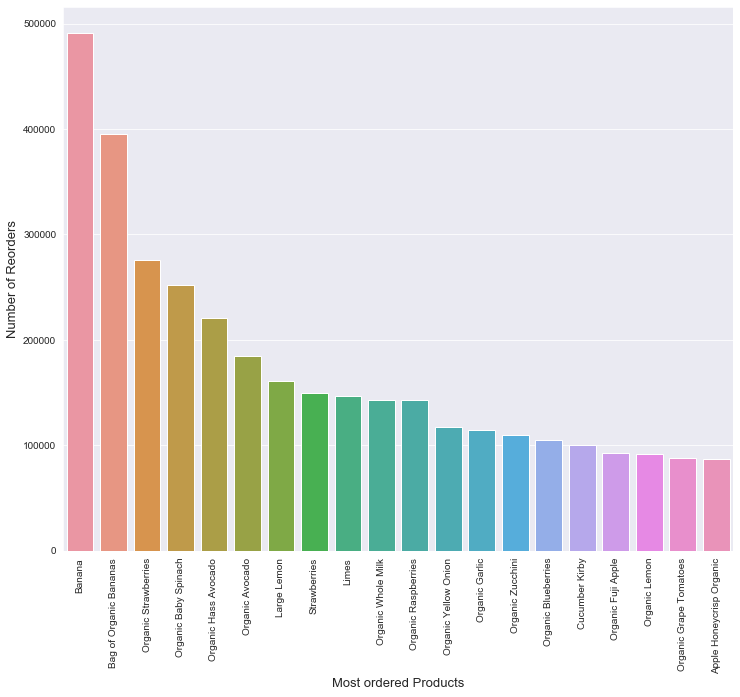

In [15]:
grouped  = df_reorder.groupby(['product_name']).sum()['Number_Reordered']
grouped = grouped.sort_values(ascending=False)
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most ordered Products', fontsize=13)
plt.show()

### Most Probable Reorder Product (descending order by prob)

In [17]:
df_reorder = most_reorder.aggregate({'reorder_sum': sum,'reorder_total': 'count'}).reset_index()
df_reorder['reorder_probability'] = df_reorder['reorder_sum'] / df_reorder['reorder_total']
df_reorder = pd.merge(df_reorder, products[['product_id', 'product_name']], how='left', on=['product_id'])
df_reorder = df_reorder[df_reorder.reorder_total > 100].sort_values(['reorder_probability'], ascending=False)[:20]
df_reorder

,product_id,reorder_sum,reorder_total,reorder_probability,product_name
27737,27740,94,102,0.921569,Chocolate Love Bar
35601,35604,93,104,0.894231,Maca Buttercups
38248,38251,99,111,0.891892,Benchbreak Chardonnay
10233,10236,114,131,0.870229,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868421,Thousand Island Salad Snax
35493,35496,394,457,0.862144,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861436,Half And Half Ultra Pasteurized
45501,45504,8091,9410,0.859830,Whole Organic Omega 3 Milk
17466,17469,416,484,0.859504,Lo-Carb Energy Drink
43391,43394,7511,8742,0.859186,Organic Lactose Free Whole Milk


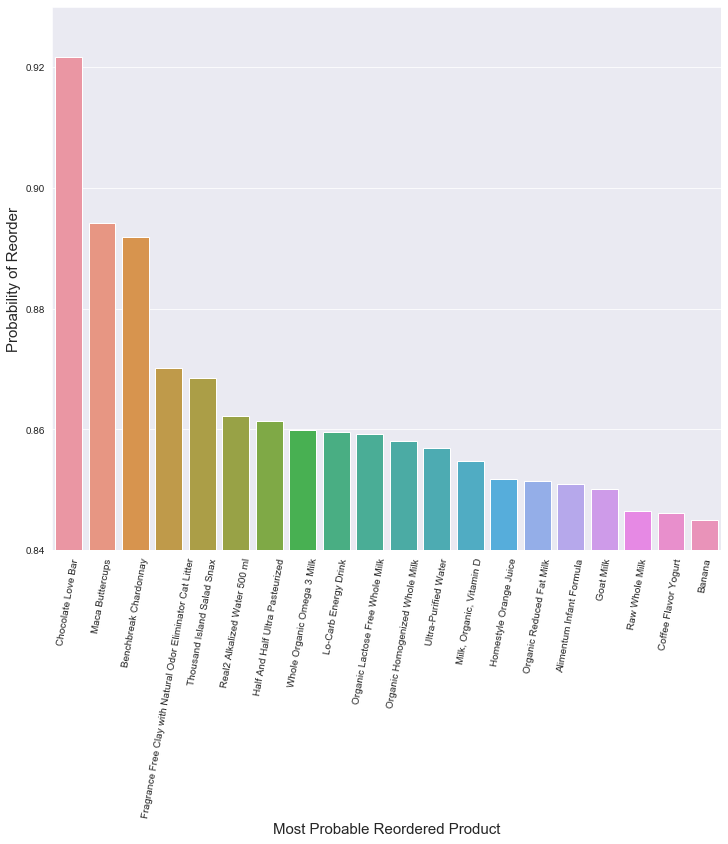

In [19]:
grouped  = df_reorder.groupby(['product_name'])
grouped = grouped.sum()['reorder_probability'].sort_values(ascending=False)
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='80')
sns.barplot(grouped.index, grouped.values)
plt.ylim([0.84,0.93])
plt.ylabel('Probability of Reorder', fontsize=15)
plt.xlabel('Most Probable Reordered Product', fontsize=15)
plt.show()

## 3. 

### Data Structure of different dataframe

1. Each row of the orders.csv represents an order made by a user
2. Different users are identified by user_id in orders.csv
3. Order are identified by order_id
4. The feature called add_to_cart_order represents the sequence in which they have been added to the cart in that order
5. for each user we may have n-1 prior orders and 1 train order or n-1 prior orders and 1 test order

In [23]:
import gc
import time
from sklearn.model_selection import train_test_split

### Dataset Merge 

In [24]:
priors_orders = orders.merge(right=priors, how='inner', on='order_id')

In [25]:
priors_orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
5,2398795,1,prior,2,3,7,15.0,196,1,1
6,2398795,1,prior,2,3,7,15.0,10258,2,0
7,2398795,1,prior,2,3,7,15.0,12427,3,1
8,2398795,1,prior,2,3,7,15.0,13176,4,0
9,2398795,1,prior,2,3,7,15.0,26088,5,1


In [26]:
# add a feature: the n-th time the user bought the item
priors_orders.loc[:,'times_user_buy'] = priors_orders.groupby(['user_id', 'product_id']).cumcount() + 1
priors_orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,times_user_buy
0,2539329,1,prior,1,2,8,NaN,196,1,0,1
1,2539329,1,prior,1,2,8,NaN,14084,2,0,1
2,2539329,1,prior,1,2,8,NaN,12427,3,0,1
3,2539329,1,prior,1,2,8,NaN,26088,4,0,1
4,2539329,1,prior,1,2,8,NaN,26405,5,0,1
5,2398795,1,prior,2,3,7,15.0,196,1,1,2
6,2398795,1,prior,2,3,7,15.0,10258,2,0,1
7,2398795,1,prior,2,3,7,15.0,12427,3,1,2
8,2398795,1,prior,2,3,7,15.0,13176,4,0,1
9,2398795,1,prior,2,3,7,15.0,26088,5,1,2


In [27]:
def add_features_1_vs_n(df, group_columns_list, agg_dict, only_new_feature=True):

    df_new = df.copy()
    grouped = df_new.groupby(group_columns_list)

    the_stats = grouped.agg(agg_dict)
    the_stats.columns = the_stats.columns.droplevel(0)
    the_stats.reset_index(inplace=True)
    if only_new_feature:
        df_new = the_stats
    else:
        df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')

    return df_new

def add_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list, keep_only_stats=True, verbose=1):
    
    dicts = {"group_columns_list": group_columns_list , "target_columns_list": target_columns_list, "methods_list" :methods_list}

    grouped_name = ''.join(group_columns_list)
    target_name = ''.join(target_columns_list)
    combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]

    df_new = df.copy()
    grouped = df_new.groupby(group_columns_list)

    the_stats = grouped[target_name].agg(methods_list).reset_index()
    the_stats.columns = [grouped_name] + \
                        ['_%s_%s_by_%s' % (grouped_name, method_name, target_name) \
                         for (grouped_name, method_name, target_name) in combine_name]
    if keep_only_stats:
        return the_stats
    else:
        df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
    return df_new

In [32]:
agg_dict = {'user_id':{'prod_tot_cnts':'count'}, 
            'reordered':{'prod_reorder_tot_cnts':'sum'}, 
            'times_user_buy': {'prod_buy_first_time_total_cnt': lambda x: sum(x==1)}}

prd = add_features_1_vs_n(priors_orders, ['product_id'], agg_dict)
prd['prod_reorder_ratio'] = prd.prod_reorder_tot_cnts / prd.prod_tot_cnts
prd['prod_reorder_times'] = 1 + prd.prod_reorder_tot_cnts / prd.prod_buy_first_time_total_cnt

In [33]:
prd

,product_id,prod_tot_cnts,prod_reorder_tot_cnts,prod_buy_first_time_total_cnt,prod_reorder_ratio,prod_reorder_times
0,1,1852,1136,716,0.613391,2.586592
1,2,90,12,78,0.133333,1.153846
2,3,277,203,74,0.732852,3.743243
3,4,329,147,182,0.446809,1.807692
4,5,15,9,6,0.600000,2.500000
5,6,8,3,5,0.375000,1.600000
6,7,30,12,18,0.400000,1.666667
7,8,165,83,82,0.503030,2.012195
8,9,156,82,74,0.525641,2.108108
9,10,2572,1304,1268,0.506998,2.028391


In [34]:
agg_dict_2 = {'order_number':{'user_total_orders':'max'},
              'days_since_prior_order':{'user_sum_days_since_prior_order':'sum', 
                                        'user_mean_days_since_prior_order': 'mean'}}
users = add_features_1_vs_n(orders[orders.eval_set == 'prior'], ['user_id'], agg_dict_2)

agg_dict_3 = {'reordered':{'user_reorder_ratio': 
               lambda x: sum(priors_orders.ix[x.index,'reordered']==1)/
                         sum(priors_orders.ix[x.index,'order_number'] > 1)},
              'product_id':{'user_total_products':'count', 
                            'user_distinct_products': lambda x: x.nunique()}}

us = add_features_1_vs_n(priors_orders, ['user_id'], agg_dict_3)
users = users.merge(us, how='inner')

users['user_average_basket'] = users.user_total_products / users.user_total_orders
us = orders[orders.eval_set != "prior"][['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
us.rename(index=str, columns={'days_since_prior_order': 'time_since_last_order'}, inplace=True)

users = users.merge(us, how='inner')

In [35]:
users

,user_id,user_total_orders,user_sum_days_since_prior_order,user_mean_days_since_prior_order,user_reorder_ratio,user_total_products,user_distinct_products,user_average_basket,order_id,eval_set,time_since_last_order
0,1,10,176.0,19.555556,0.759259,59,18,5.900000,1187899,train,14.0
1,2,14,198.0,15.230769,0.510989,195,102,13.928571,1492625,train,30.0
2,3,12,133.0,12.090909,0.705128,88,33,7.333333,2774568,test,11.0
3,4,5,55.0,13.750000,0.071429,18,17,3.600000,329954,test,30.0
4,5,4,40.0,13.333333,0.538462,37,23,9.250000,2196797,train,6.0
5,6,3,18.0,9.000000,0.200000,14,12,4.666667,1528013,test,22.0
6,7,20,203.0,10.684211,0.711340,206,68,10.300000,525192,train,6.0
7,8,3,60.0,30.000000,0.464286,49,36,16.333333,880375,train,10.0
8,9,3,36.0,18.000000,0.391304,76,58,25.333333,1094988,train,30.0
9,10,5,79.0,19.750000,0.355072,143,94,28.600000,1822501,train,30.0


In [36]:
agg_dict_4 = {'order_number':{'up_order_count': 'count', 
                              'up_first_order_number': 'min', 
                              'up_last_order_number':'max'}, 
              'add_to_cart_order':{'up_average_cart_position': 'mean'}}

data = add_features_1_vs_n(df=priors_orders, group_columns_list=['user_id', 'product_id'], 
                                    agg_dict=agg_dict_4)

data = data.merge(prd, how='inner', on='product_id').merge(users, how='inner', on='user_id')

data['up_order_rate'] = data.up_order_count / data.user_total_orders
data['up_order_since_last_order'] = data.user_total_orders - data.up_last_order_number
data['up_order_rate_since_first_order'] = data.up_order_count / (data.user_total_orders - data.up_first_order_number + 1)

In [37]:
data

,user_id,product_id,up_order_count,up_first_order_number,up_last_order_number,up_average_cart_position,prod_tot_cnts,prod_reorder_tot_cnts,prod_buy_first_time_total_cnt,prod_reorder_ratio,...,user_reorder_ratio,user_total_products,user_distinct_products,user_average_basket,order_id,eval_set,time_since_last_order,up_order_rate,up_order_since_last_order,up_order_rate_since_first_order
0,1,196,10,1,10,1.400000,35791,27791,8000,0.776480,...,0.759259,59,18,5.900000,1187899,train,14.0,1.000000,0,1.000000
1,1,10258,9,2,10,3.333333,1946,1389,557,0.713772,...,0.759259,59,18,5.900000,1187899,train,14.0,0.900000,0,1.000000
2,1,10326,1,5,5,5.000000,5526,3603,1923,0.652009,...,0.759259,59,18,5.900000,1187899,train,14.0,0.100000,5,0.166667
3,1,12427,10,1,10,3.300000,6476,4797,1679,0.740735,...,0.759259,59,18,5.900000,1187899,train,14.0,1.000000,0,1.000000
4,1,13032,3,2,10,6.333333,3751,2465,1286,0.657158,...,0.759259,59,18,5.900000,1187899,train,14.0,0.300000,0,0.333333
5,1,13176,2,2,5,6.000000,379450,315913,63537,0.832555,...,0.759259,59,18,5.900000,1187899,train,14.0,0.200000,5,0.222222
6,1,14084,1,1,1,2.000000,15935,12923,3012,0.810982,...,0.759259,59,18,5.900000,1187899,train,14.0,0.100000,9,0.100000
7,1,17122,1,5,5,6.000000,13880,9377,4503,0.675576,...,0.759259,59,18,5.900000,1187899,train,14.0,0.100000,5,0.166667
8,1,25133,8,3,10,4.000000,6196,4586,1610,0.740155,...,0.759259,59,18,5.900000,1187899,train,14.0,0.800000,0,1.000000
9,1,26088,2,1,2,4.500000,2523,1360,1163,0.539041,...,0.759259,59,18,5.900000,1187899,train,14.0,0.200000,8,0.200000


In [38]:
train = train.merge(right=orders[['order_id', 'user_id']], 
                    how='left', on='order_id')
data = data.merge(train[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')

In [39]:
data

,user_id,product_id,up_order_count,up_first_order_number,up_last_order_number,up_average_cart_position,prod_tot_cnts,prod_reorder_tot_cnts,prod_buy_first_time_total_cnt,prod_reorder_ratio,...,user_total_products,user_distinct_products,user_average_basket,order_id,eval_set,time_since_last_order,up_order_rate,up_order_since_last_order,up_order_rate_since_first_order,reordered
0,1,196,10,1,10,1.400000,35791,27791,8000,0.776480,...,59,18,5.900000,1187899,train,14.0,1.000000,0,1.000000,1.0
1,1,10258,9,2,10,3.333333,1946,1389,557,0.713772,...,59,18,5.900000,1187899,train,14.0,0.900000,0,1.000000,1.0
2,1,10326,1,5,5,5.000000,5526,3603,1923,0.652009,...,59,18,5.900000,1187899,train,14.0,0.100000,5,0.166667,NaN
3,1,12427,10,1,10,3.300000,6476,4797,1679,0.740735,...,59,18,5.900000,1187899,train,14.0,1.000000,0,1.000000,NaN
4,1,13032,3,2,10,6.333333,3751,2465,1286,0.657158,...,59,18,5.900000,1187899,train,14.0,0.300000,0,0.333333,1.0
5,1,13176,2,2,5,6.000000,379450,315913,63537,0.832555,...,59,18,5.900000,1187899,train,14.0,0.200000,5,0.222222,NaN
6,1,14084,1,1,1,2.000000,15935,12923,3012,0.810982,...,59,18,5.900000,1187899,train,14.0,0.100000,9,0.100000,NaN
7,1,17122,1,5,5,6.000000,13880,9377,4503,0.675576,...,59,18,5.900000,1187899,train,14.0,0.100000,5,0.166667,NaN
8,1,25133,8,3,10,4.000000,6196,4586,1610,0.740155,...,59,18,5.900000,1187899,train,14.0,0.800000,0,1.000000,1.0
9,1,26088,2,1,2,4.500000,2523,1360,1163,0.539041,...,59,18,5.900000,1187899,train,14.0,0.200000,8,0.200000,1.0


[0]	train-logloss:0.62562
[10]	train-logloss:0.33519
[20]	train-logloss:0.26795
[30]	train-logloss:0.25054
[40]	train-logloss:0.24588
[50]	train-logloss:0.24421
[60]	train-logloss:0.24351
[70]	train-logloss:0.24296
[79]	train-logloss:0.24261


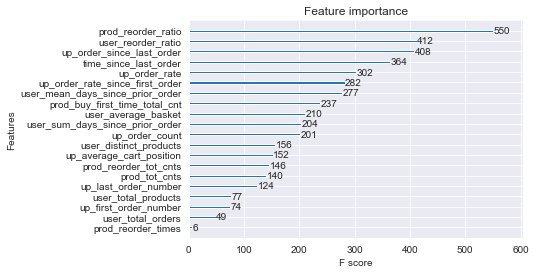

In [58]:
import xgboost

train = data.loc[data.eval_set == "train",:]
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
train.loc[:, 'reordered'] = train.reordered.fillna(0)

X_train, x_test, y_train, y_test = train_test_split(train.drop('reordered', axis=1), train.reordered,
                                                    test_size=0.9, random_state=42)
d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

In [41]:
X_test = data.loc[data.eval_set == "test",:]
X_test = X_test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1)

In [42]:
X_test

,up_order_count,up_first_order_number,up_last_order_number,up_average_cart_position,prod_tot_cnts,prod_reorder_tot_cnts,prod_buy_first_time_total_cnt,prod_reorder_ratio,prod_reorder_times,user_total_orders,user_sum_days_since_prior_order,user_mean_days_since_prior_order,user_reorder_ratio,user_total_products,user_distinct_products,user_average_basket,time_since_last_order,up_order_rate,up_order_since_last_order,up_order_rate_since_first_order
18,5,15,22,2.200000,35791,27791,8000,0.776480,4.473875,22,227.0,10.809524,0.867647,72,13,3.272727,7.0,0.227273,0,0.625000
19,10,1,20,2.100000,6476,4797,1679,0.740735,3.857058,22,227.0,10.809524,0.867647,72,13,3.272727,7.0,0.454545,2,0.454545
20,4,8,19,3.500000,1448,886,562,0.611878,2.576512,22,227.0,10.809524,0.867647,72,13,3.272727,7.0,0.181818,3,0.266667
21,8,1,22,2.375000,2909,2042,867,0.701959,3.355248,22,227.0,10.809524,0.867647,72,13,3.272727,7.0,0.363636,0,0.363636
22,10,1,19,1.600000,4081,3000,1081,0.735114,3.775208,22,227.0,10.809524,0.867647,72,13,3.272727,7.0,0.454545,3,0.454545
23,11,1,20,2.454545,8848,5723,3125,0.646813,2.831360,22,227.0,10.809524,0.867647,72,13,3.272727,7.0,0.500000,2,0.500000
24,8,2,20,3.125000,1597,1024,573,0.641202,2.787086,22,227.0,10.809524,0.867647,72,13,3.272727,7.0,0.363636,2,0.380952
25,1,5,5,3.000000,186,64,122,0.344086,1.524590,22,227.0,10.809524,0.867647,72,13,3.272727,7.0,0.045455,17,0.055556
26,1,6,6,3.000000,562,155,407,0.275801,1.380835,22,227.0,10.809524,0.867647,72,13,3.272727,7.0,0.045455,16,0.058824
27,9,2,19,2.111111,12068,9443,2625,0.782483,4.597333,22,227.0,10.809524,0.867647,72,13,3.272727,7.0,0.409091,3,0.428571


In [43]:
X_train

,up_order_count,up_first_order_number,up_last_order_number,up_average_cart_position,prod_tot_cnts,prod_reorder_tot_cnts,prod_buy_first_time_total_cnt,prod_reorder_ratio,prod_reorder_times,user_total_orders,user_sum_days_since_prior_order,user_mean_days_since_prior_order,user_reorder_ratio,user_total_products,user_distinct_products,user_average_basket,time_since_last_order,up_order_rate,up_order_since_last_order,up_order_rate_since_first_order
2785200,1,8,8,31.000000,2145,529,1616,0.246620,1.327351,42,355.0,8.658537,0.668599,1062,370,25.285714,6.0,0.023810,34,0.028571
5090964,5,1,22,24.000000,45530,25877,19653,0.568351,2.316695,23,292.0,13.272727,0.794872,593,159,25.782609,7.0,0.217391,1,0.217391
792885,1,12,12,20.000000,5712,2655,3057,0.464811,1.868499,21,226.0,11.300000,0.548747,365,168,17.380952,7.0,0.047619,9,0.100000
13078912,2,3,4,2.000000,1208,610,598,0.504967,2.020067,4,60.0,20.000000,0.416667,19,14,4.750000,30.0,0.500000,0,1.000000
7103231,4,7,32,3.750000,3076,2041,1035,0.663524,2.971981,34,331.0,10.030303,0.608696,409,171,12.029412,0.0,0.117647,2,0.142857
12387549,1,1,1,10.000000,11029,6336,4693,0.574485,2.350096,42,350.0,8.536585,0.733634,456,131,10.857143,7.0,0.023810,41,0.023810
10489517,6,1,8,2.333333,2823,1747,1076,0.618845,2.623606,8,119.0,17.000000,0.816901,95,37,11.875000,13.0,0.750000,0,0.750000
11773762,1,3,3,3.000000,3744,2072,1672,0.553419,2.239234,10,117.0,13.000000,0.296875,69,50,6.900000,17.0,0.100000,7,0.125000
4974362,1,17,17,2.000000,2055,981,1074,0.477372,1.913408,55,347.0,6.425926,0.635108,513,191,9.327273,5.0,0.018182,38,0.025641
7796057,2,2,5,22.000000,165,37,128,0.224242,1.289062,6,122.0,24.400000,0.361345,159,116,26.500000,16.0,0.333333,1,0.400000


### Logistic Regression

In [84]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# Fit to data, then transform it.
X_train = sc.fit_transform(X_train)
# Perform standardization by centering and scaling
x_test = sc.transform(x_test)

In [85]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [86]:
y_pred = classifier.predict(x_test)

In [87]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy classification score is:", accuracy_score(y_test, y_pred))

[[6807861   73466]
 [ 632612  113256]]
Accuracy classification score is: 0.9074262556549295


### optional: Random Forest (bagging)

In [88]:
# from sklearn.ensemble import RandomForestClassifier
# classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(x_test)

# from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
# cm = confusion_matrix(y_test, y_pred)
# print(cm)
# print("Accuracy classification score is:", accuracy_score(y_test, y_pred))

### Gradient Boosting

In [90]:
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier(random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(x_test)

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy classification score is:", accuracy_score(y_test, y_pred))

[[6805451   75876]
 [ 616806  129062]]
Accuracy classification score is: 0.9091826025163904


### XGBoost

In [89]:
from xgboost import XGBClassifier
classifier = XGBClassifier(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(x_test)

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy classification score is:", accuracy_score(y_test, y_pred))

[[6797556   83771]
 [ 604497  141371]]
Accuracy classification score is: 0.9097613211672181
